In [1]:
import numpy as np
from scqubits import Fluxonium

def calculate_spectrum(flxs, EJ, EC, EL, evals_count=4, cutoff=50):
    fluxonium = Fluxonium(EJ, EC, EL, flux=0.0, cutoff=cutoff, truncated_dim=evals_count)
    spectrumData = fluxonium.get_spectrum_vs_paramvals(
        "flux", flxs, evals_count=evals_count
    )

    return spectrumData.energy_table

In [2]:
EJb = (4.0, 6.0)
ECb = (0.5, 1.0)
ELb = (1.0, 2.0)

transitions = [(0, 1), (0, 2), (1, 2), (0, 3), (1, 3), (0, 4)]
weights = np.array([2, 1, 0.5, 0.5, 0.2, 0.2])

max_level = 5

# load data

In [4]:
def load_data(file_path):
    import h5py
    with h5py.File(file_path, "r") as file:
        data = file["Data"]['Data']
        if data.shape[2] == 1: # 1D data,
            x_data = data[:, 0, 0][:]
            y_data = None
            z_data = data[:, 1, 0][:] + 1j * data[:, 2, 0][:]
        else:
            x_data = data[:, 0, 0][:]
            y_data = data[0, 1, :][:]
            z_data = data[:, 2, :][:] + 1j * data[:, 3, :][:]
    return z_data, x_data, y_data

spectrum, fpts, flxs = load_data("qub_flux_dep.hdf5")
fpts /= 1e9 # convert to GHz
spectrum = np.abs(spectrum)
spectrum -= np.median(spectrum, axis=0)

if flxs[0] > flxs[-1]: # Ensure that the fluxes are in increasing
    flxs = flxs[::-1]
    spectrum = spectrum[:, ::-1]

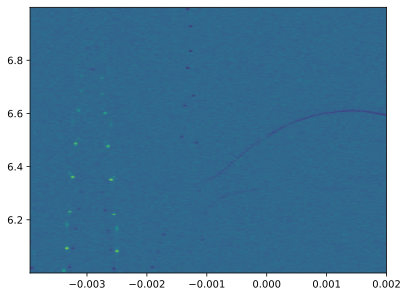

In [5]:
import matplotlib.pyplot as plt

plt.imshow(spectrum, aspect='auto', origin='lower', extent=(flxs[0], flxs[-1], fpts[0], fpts[-1]))

In [14]:
center = -0.002935
halfp = 0.00436

cflxs = (flxs - center) / (2*halfp) + 0.5

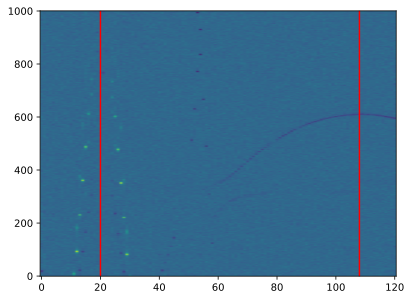

In [15]:
import matplotlib.pyplot as plt

plt.imshow(spectrum, aspect='auto', origin='lower')
plt.axvline(np.argmin(np.abs(cflxs - 0.5)), color='r')
plt.axvline(np.argmin(np.abs(cflxs - 1.0)), color='r')

In [16]:
flxs = cflxs

# NN

In [17]:
# make the spectrum symmetric around 0.5
center_idx = np.argmin(np.abs(flxs - 0.5)).item()
period_len = int(1.0 / (flxs[1] - flxs[0]))

# pad the spectrum with zeros to make it symmetric
pad_before = period_len - center_idx
pad_after = period_len - (len(flxs) - center_idx + 1)
n_spectrum = np.pad(spectrum, ((0, 0), (pad_before, pad_after)), 'constant')
center_id = center_idx + pad_before

# flip filled part of the spectrum
n_spectrum = np.where(n_spectrum != 0, n_spectrum, n_spectrum[:, ::-1])

# truncate the spectrum to the period
n_spectrum = n_spectrum[:, center_id - period_len//2:center_id + period_len//2]
pad_flxs = np.linspace(-0.0, 1.0, n_spectrum.shape[1])

# resample to (300, 121)
sample_fpts = np.linspace(fpts[0], fpts[-1], 300)
n_spectrum = np.array([
    np.interp(sample_fpts, fpts, n_spectrum[:, i]) for i in range(n_spectrum.shape[1])
]).T
sample_flxs = np.linspace(0.0, 1.0, 121)
n_spectrum = np.array([
    np.interp(sample_flxs, pad_flxs, n_spectrum[i, :]) for i in range(n_spectrum.shape[0])
])

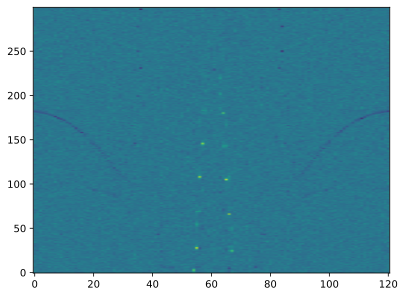

In [18]:
import matplotlib.pyplot as plt

plt.imshow(n_spectrum, aspect='auto', origin='lower')

In [ ]:
# fit the spectrumData
import torch
from modules.model import PredictNet
from modules.baseblock import ResNet18
from torch.nn import MSELoss

model_path = "ckpt/resnet18_f3.pth"
model = PredictNet(ResNet18)
model.load_state_dict(torch.load(model_path, weights_only=True))
criterion = MSELoss()

model.eval()
model.cuda()
criterion.cuda()
with torch.no_grad():
    nn_params = model(torch.tensor(
        n_spectrum.T,
        dtype=torch.float32,
        device="cuda"
    )[None, ...]).cpu().numpy()[0].tolist()

    nn_params = (
        nn_params[0] * (EJb[1] - EJb[0]) + EJb[0],
        nn_params[1] * (ECb[1] - ECb[0]) + ECb[0],
        nn_params[2] * (ELb[1] - ELb[0]) + ELb[0],
    )

# print the results
print("Fitted params:", *nn_params)

In [ ]:
f_energies = calculate_spectrum(sample_flxs, *nn_params, max_level, 50)

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(n_spectrum, aspect='auto', origin='lower', extent=(sample_flxs[0], sample_flxs[-1], sample_fpts[0], sample_fpts[-1]))

for i, j in transitions:
    plt.plot(sample_flxs, f_energies[:, j] - f_energies[:, i], label=f"{i}-{j}")

plt.ylim(sample_fpts[0], sample_fpts[-1])
plt.legend()
plt.show()

# Scipy

In [30]:
nn_params = (
    0.5*(EJb[0] + EJb[1]),
    0.5*(ECb[0] + ECb[1]),
    0.5*(ELb[0] + ELb[1]),
)

In [19]:
from scipy.ndimage import gaussian_filter1d

def NormalizeData(signals2D: np.ndarray, axis=None) -> np.ndarray:
    # normalize on given axis
    mins = np.nanmin(signals2D, axis=axis, keepdims=True)
    maxs = np.nanmax(signals2D, axis=axis, keepdims=True)
    meds = np.nanmedian(signals2D, axis=axis, keepdims=True)
    return (signals2D - meds) / (maxs - mins)

def spectrum_analyze(flxs, fpts, amps, ratio):
    """
    flxs: 1D array, flux points
    fpts: 1D array, frequency points
    amps: 2D array, shape: (len(fpts), len(flxs))
    """
    # use guassian filter to smooth the spectrum
    amps = gaussian_filter1d(amps, 3, axis=0)
    amps = NormalizeData(amps, 0)  # normalize on frequency axis
    amps = np.abs(amps)

    # plot max point and min point of each row
    max_ids = np.argmax(amps, axis=0)
    maxs = amps[max_ids, np.arange(amps.shape[1])]

    # max points
    max_masks = maxs >= ratio
    fs = fpts[max_ids]
    fs[~max_masks] = np.nan
    mask = ~np.isnan(fs)

    return flxs[mask], fs[mask]

def remove_close_points(flxs, fs, t_ratio):
    # remove close points
    mask = np.ones(flxs.shape, dtype=bool)
    t_d = np.sqrt((flxs[-1] - flxs[0])**2 + (fs[-1] - fs[0])**2)
    prev = 0
    for i in range(1, len(flxs)):
        d_flx = flxs[i] - flxs[prev]
        d_fs = fs[i] - fs[prev]
        d2 = np.sqrt(d_flx**2 + d_fs**2)
        if d2 < t_d * t_ratio:
            mask[i] = False
        else:
            prev = i
    return flxs[mask], fs[mask]

s_flxs, s_fs = spectrum_analyze(flxs, fpts, spectrum, 0.75)

In [20]:
# remove some close points
s_flxs, s_fs = remove_close_points(s_flxs, s_fs, 0.01)

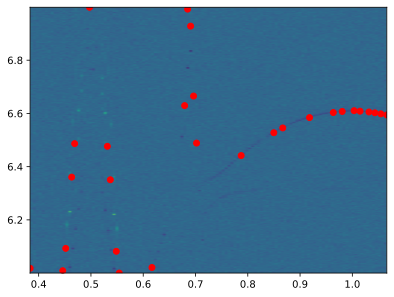

In [21]:
import matplotlib.pyplot as plt

plt.imshow(spectrum, aspect='auto', origin='lower', extent=(flxs[0], flxs[-1], fpts[0], fpts[-1]))
plt.scatter(s_flxs, s_fs, c='r')

In [41]:
from scipy.optimize import minimize


def fit_spectrum(flxs, fpts, params):
    """
    Fit the fluxonium spectrum to the experimental spectrum
    flxs: 1D array of flux values, shape (n,)
    fpts: 2D array of transition frequencies, shape (n,)
    """

    def loss_func(params):
        energies = calculate_spectrum(flxs, *params, max_level, cutoff=50)

        # only fit 0-1, 0-2, 1-2, 0-3, 1-3
        fs = []
        for i, j in transitions:
            fs.append(energies[:, j] - energies[:, i])
        fs = np.stack(fs, axis=1) # (n, m)
        dist = np.abs(fpts[:, None] - fs) # (n, m)
        dist = dist / weights[None, :] # make some transitions more attractive
        loss_fs = np.nanmin(dist, axis=1) # (n,)

        return np.nansum(loss_fs)

    # aim to find current curve
    res1 = minimize(
        loss_func,
        params,
        bounds=(EJb, ECb, ELb),
        method="L-BFGS-B",
        options={"maxfun": 50},
    )

    def loss_func2(params):
        energies = calculate_spectrum(flxs, *params, max_level, cutoff=50)
        fs = []
        for i, j in transitions:
            fs.append(energies[:, j] - energies[:, i])
        fs = np.stack(fs, axis=1)

        dist = np.abs(fpts[:, None] - fs) # (n, m)
        min_ids = np.argmin(dist, axis=1)
        dist = dist[np.arange(len(min_ids)), min_ids] # (n,)
        dist = dist * weights[min_ids] # make some transitions more penalized

        return np.nansum(dist)

    # aim to fitting to close curve
    res2 = minimize(
        loss_func2,
        res1.x,
        bounds=(EJb, ECb, ELb),
        method="L-BFGS-B",
        options={"maxfun": 40},
    )

    return res2.x

In [ ]:
# fit the spectrumData
sp_params = fit_spectrum(s_flxs, s_fs, params=nn_params)

# print the results
print("Fitted params:", *sp_params)

In [ ]:
f_energies = calculate_spectrum(flxs, *sp_params, max_level, 50)

In [ ]:
# plt.pcolormesh(flxs, fpts, spectrum)
plt.imshow(spectrum, aspect='auto', origin='lower', extent=(flxs[0], flxs[-1], fpts[0], fpts[-1]))

for i, j in transitions:
    plt.plot(flxs, f_energies[:, j] - f_energies[:, i], label=f"{i}-{j}")

plt.scatter(s_flxs, s_fs, color="red")
plt.ylim(fpts[0], fpts[-1])
plt.legend()
plt.show()